In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    h = np.clip(h, 1e-10, 1-1e-10)
    return -(1/m) * np.sum(y*np.log(h) + (1-y)*np.log(1-h))

def compute_gradient(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    return (1/m) * (X.T @ (h - y))

def gradient_descent(X, y, theta, alpha, num_iters):
    J_history = []
    for i in range(num_iters):
        grad = compute_gradient(X, y, theta)
        theta -= alpha * grad
        J_history.append(compute_cost(X, y, theta))
    return theta, J_history

def reduce_categories(df, col, top_n=5):
    counts = df[col].value_counts()
    top_categories = counts.index[:top_n]
    df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df

Importing and Modifying Training Data

In [4]:
df_train = pd.read_csv("crime_train.csv")
df_train = df_train.drop(columns=["Unnamed: 0", "Num", "case_filed"])
df_train["closed"] = df_train["closed"].map({"Yes":1, "No":0})

y_train = df_train["closed"]
X_train = df_train.drop(columns=["closed"])

# Apply category reduction
high_card_features = ["city", "crime_description", "weapon", "domain"]
for col in high_card_features:
    X_train = reduce_categories(X_train, col, top_n=5)

# One-hot encode
features = ["city", "crime_description", "sex", "weapon", "domain"]
X_train = pd.get_dummies(X_train, columns=features, drop_first=False)

# Save column names AFTER reduction & encoding
col_names = ['bias'] + list(X_train.columns)

# Standardize
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / (X_std + 1e-8)

# Add bias term
X_train = np.c_[np.ones(X_train.shape[0]), X_train]

# Convert to numpy arrays
X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=float)
w_i = np.zeros(X_train.shape[1])

Training the model : 

In [7]:
epochs = 3000
alpha = 0.01
print("Training initiated...")
w_f, J_history = gradient_descent(X_train, y_train, w_i, alpha, epochs)

weights_df = pd.DataFrame({'feature': col_names, 'weight': w_f})
weights_df = weights_df.reindex(weights_df.weight.abs().sort_values(ascending=False).index)
print("\nTop 10 weights:")
print(weights_df.head(10))
print("Final cost:", J_history[-1])

Training initiated...

Top 10 weights:
                      feature    weight
12    crime_description_FRAUD  0.026093
20          weapon_Explosives -0.025667
8                 city_Mumbai -0.019347
27       domain_Violent Crime  0.015250
23              weapon_Poison  0.014165
7              city_Hyderabad  0.013299
14  crime_description_ROBBERY -0.011019
24       domain_Fire Accident -0.010811
25         domain_Other Crime -0.010647
18                      sex_X  0.009797
Final cost: 0.6926773019343347


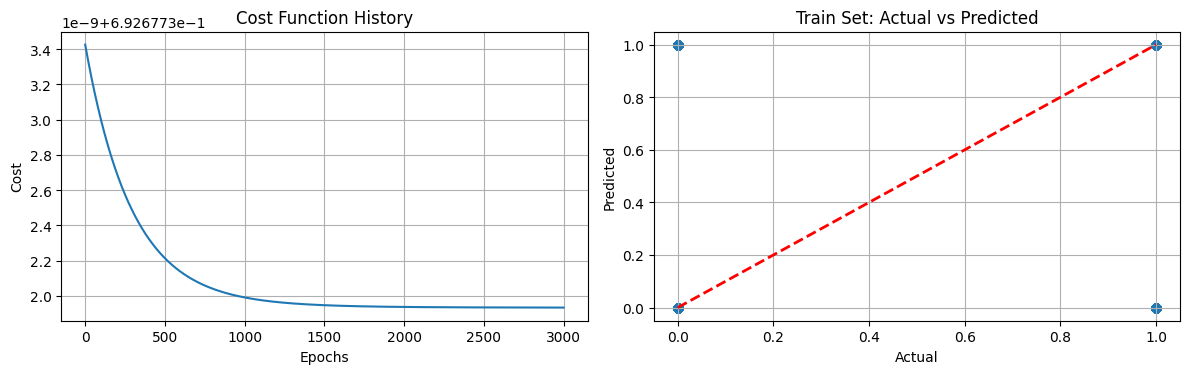

In [8]:
pred_prob_train = sigmoid(X_train @ w_f)
threshold = 0.5
pred_class_train = (pred_prob_train >= threshold).astype(int)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(J_history)
plt.title('Cost Function History')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(y_train, pred_class_train, alpha=0.5)
plt.plot([0,1],[0,1],'r--', lw=2)
plt.title('Train Set: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

testing accuracy of the model using a Confusion Matrix

In [9]:
TP = np.sum((y_train==1) & (pred_class_train==1))
TN = np.sum((y_train==0) & (pred_class_train==0))
FP = np.sum((y_train==0) & (pred_class_train==1))
FN = np.sum((y_train==1) & (pred_class_train==0))
print("\nTrain Confusion Matrix:")
print(f"TP: {TP}, FP: {FP}")
print(f"FN: {FN}, TN: {TN}")
accuracy_train = (TP + TN) / len(y_train)
print("Training accuracy:", accuracy_train)


Train Confusion Matrix:
TP: 6011, FP: 5734
FN: 5242, TN: 5502
Training accuracy: 0.5119391702610165


Importing and Preprocessing Test Data

In [10]:
df_test = pd.read_csv("crime_test.csv")
df_test = df_test.drop(columns=["Unnamed: 0", "Num", "case_filed"])
df_test["closed"] = df_test["closed"].map({"Yes":1, "No":0})
y_test = df_test["closed"]
X_test = df_test.drop(columns=["closed"])

for col in high_card_features:
    train_top = X_train[:,1:].shape
    counts_train = df_train[col].value_counts()
    top_categories = counts_train.index[:5]
    X_test[col] = X_test[col].apply(lambda x: x if x in top_categories else 'Other')

X_test = pd.get_dummies(X_test, columns=features, drop_first=False)

for col in col_names[1:]:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[col_names[1:]]

X_test = (X_test - X_mean) / (X_std + 1e-8)
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=float)

Prediction on Test Data

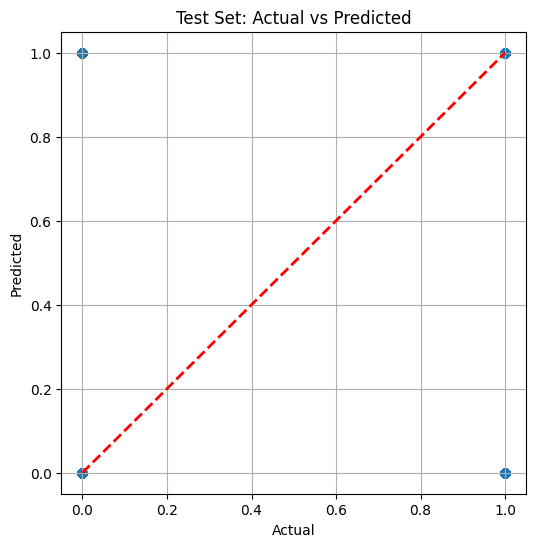

In [11]:
pred_prob_test = sigmoid(X_test @ w_f)
pred_class_test = (pred_prob_test >= threshold).astype(int)

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_class_test, alpha=0.5)
plt.plot([0,1],[0,1],'r--', lw=2)
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()

Testing Accuracy : 

In [13]:
TP_test = np.sum((y_test==1) & (pred_class_test==1))
TN_test = np.sum((y_test==0) & (pred_class_test==0))
FP_test = np.sum((y_test==0) & (pred_class_test==1))
FN_test = np.sum((y_test==1) & (pred_class_test==0))
print("\nTest Confusion Matrix:")
print(f"TP: {TP_test}, FP: {FP_test}")
print(f"FN: {FN_test}, TN: {TN_test}")
accuracy_test = (TP_test + TN_test) / len(y_test)
print("Test accuracy:", accuracy_test)


Test Confusion Matrix:
TP: 2473, FP: 2498
FN: 2350, TN: 2318
Test accuracy: 0.4970432617491441
